# Face Detection & Recognition Pipeline Simulation

This notebook simulates the complete face detection and recognition pipeline that runs on the STM32N6570-DK embedded board. It uses the same trump2.jpg image and models to help validate and understand the pipeline behavior.

## Pipeline Overview
1. **Input Processing**: Load and preprocess trump2.jpg (480x480 centered in 800x480 with black padding)
2. **Face Detection**: Use CenterFace ONNX model to detect faces
3. **Face Cropping**: Extract and align detected face regions
4. **Face Recognition**: Use MobileFaceNet ONNX model to generate embeddings
5. **Similarity Calculation**: Compare with target embedding

## Expected Results
Based on the embedded implementation hints:
- **Detection coordinates**: cx=245.497, cy=261.098, w=246.817, h=313.832
- **Face landmarks**: lx=200.221, ly=226.327, rx=297.419, ry=225.127
- **Cropped face first pixels**: [80, 172, 40, 96, 100, ...]
- **Recognition embedding sample**: [0.176, -0.224, 0.179, 0.051, ...]


In [1]:
import numpy as np
import cv2
from PIL import Image
import onnxruntime as ort
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Configuration matching embedded system
NN_WIDTH = 128
NN_HEIGHT = 128
NN_BPP = 3

IMG_BUFFER_WIDTH = 800
IMG_BUFFER_HEIGHT = 480

FR_WIDTH = 112  # Face recognition input width
FR_HEIGHT = 112  # Face recognition input height

EMBEDDING_SIZE = 128

print("🚀 Face Detection & Recognition Pipeline Simulation")
print(f"📐 Neural Network Input: {NN_WIDTH}x{NN_HEIGHT}x{NN_BPP}")
print(f"📸 Camera Frame: {IMG_BUFFER_WIDTH}x{IMG_BUFFER_HEIGHT}")
print(f"👤 Face Recognition: {FR_WIDTH}x{FR_HEIGHT}")

🚀 Face Detection & Recognition Pipeline Simulation
📐 Neural Network Input: 128x128x3
📸 Camera Frame: 800x480
👤 Face Recognition: 112x112


## Step 1: Load and Prepare Input Image

Load trump2.jpg and create the same dual buffer system used in the embedded implementation:
- `img_buffer`: 480x480 centered in 800x480 RGB565 (for face cropping)
- `nn_rgb`: 128x128 RGB888 (for neural network input)

📂 Loading ../Exercises/SamplePics/trump2.jpg...
   Original: (432, 432) RGB
✅ img_buffer: (480, 800, 3) (480x480 centered)
✅ nn_rgb: (128, 128, 3)


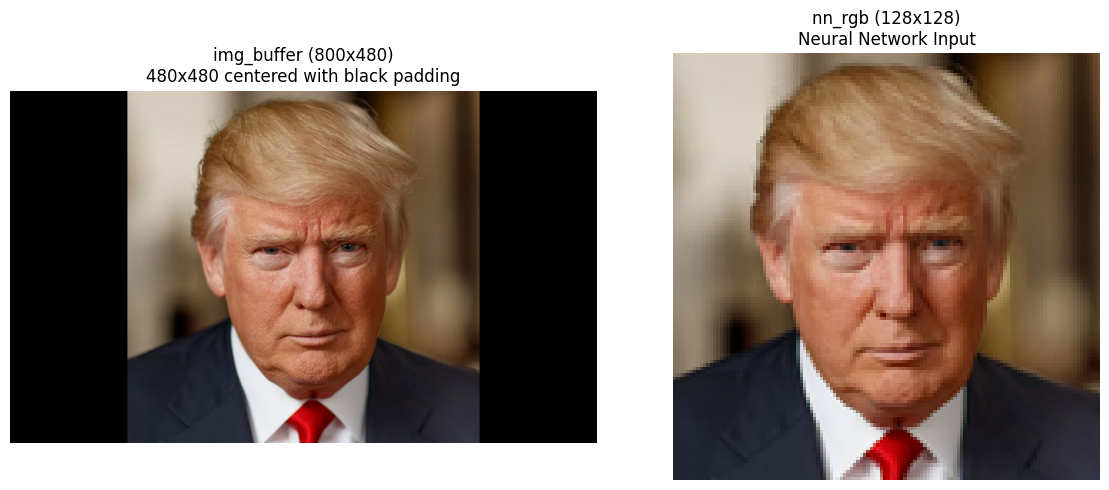

🔍 First few nn_rgb pixels: [206, 196, 180, 209, 199, 183, 211, 202, 188, 212]


In [2]:
def rgb888_to_rgb565(r, g, b):
    """Convert RGB888 to RGB565"""
    r565 = (r >> 3) & 0x1F
    g565 = (g >> 2) & 0x3F
    b565 = (b >> 3) & 0x1F
    return (r565 << 11) | (g565 << 5) | b565

def rgb565_to_rgb888(rgb565):
    """Convert RGB565 back to RGB888"""
    r = ((rgb565 >> 11) & 0x1F) << 3
    g = ((rgb565 >> 5) & 0x3F) << 2
    b = (rgb565 & 0x1F) << 3
    return r, g, b

def create_dual_buffers(img_path):
    """Create dual buffers matching embedded implementation"""
    
    # Load trump2.jpg
    print(f"📂 Loading {img_path}...")
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    print(f"   Original: {img.size} {img.mode}")
    
    # Create img_buffer: 480x480 centered in 800x480
    img_buffer_480 = img.resize((480, 480), Image.LANCZOS)
    img_buffer_rgb = np.zeros((IMG_BUFFER_HEIGHT, IMG_BUFFER_WIDTH, 3), dtype=np.uint8)
    
    # Center the 480x480 image in 800x480 canvas
    left_padding = (IMG_BUFFER_WIDTH - 480) // 2  # 160 pixels
    img_buffer_rgb[:, left_padding:left_padding+480, :] = np.array(img_buffer_480)
    
    # Create nn_rgb: 128x128 RGB888
    nn_rgb = np.array(img.resize((NN_WIDTH, NN_HEIGHT), Image.LANCZOS), dtype=np.uint8)
    
    print(f"✅ img_buffer: {img_buffer_rgb.shape} (480x480 centered)")
    print(f"✅ nn_rgb: {nn_rgb.shape}")
    
    return img_buffer_rgb, nn_rgb

# Load trump2.jpg and create dual buffers
trump2_path = "../Exercises/SamplePics/trump2.jpg"
img_buffer, nn_rgb = create_dual_buffers(trump2_path)

# Visualize the dual buffer setup
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(img_buffer)
axes[0].set_title(f"img_buffer ({IMG_BUFFER_WIDTH}x{IMG_BUFFER_HEIGHT})\n480x480 centered with black padding")
axes[0].axis('off')

axes[1].imshow(nn_rgb)
axes[1].set_title(f"nn_rgb ({NN_WIDTH}x{NN_HEIGHT})\nNeural Network Input")
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"🔍 First few nn_rgb pixels: {nn_rgb.flatten()[:10].tolist()}")

## Step 2: Face Detection with CenterFace

Use the CenterFace ONNX model to detect faces in the 128x128 input image.

In [3]:
def preprocess_for_detection(rgb_img):
    """Preprocess RGB image for CenterFace model (CHW format, float32)"""
    # Convert to float32 
    img_float = rgb_img.astype(np.float32)
    
    # Convert from HWC to CHW format
    img_chw = np.transpose(img_float, (2, 0, 1))
    
    # Add batch dimension
    img_batch = np.expand_dims(img_chw, axis=0)
    
    print(f"   Detection input shape: {img_batch.shape}")
    print(f"   Detection input range: [{img_batch.min():.3f}, {img_batch.max():.3f}]")
    print(f"   Detection input dtype: {img_batch.dtype}")
    print(f"   First 10 input values: {img_batch.flatten()[:10]}")
    
    return img_batch

def analyze_output_differences(outputs, output_names=None):
    """Analyze CenterFace outputs for debugging differences"""
    if output_names is None:
        output_names = ["Scale", "Landmarks", "Heatmap", "Offset"]
    
    print(f"\n🔍 Detailed CenterFace Output Analysis:")
    
    for i, output in enumerate(outputs):
        name = output_names[i] if i < len(output_names) else f"Output_{i}"
        
        print(f"\n📊 {name} (Output {i}):")
        print(f"   Shape: {output.shape}")
        print(f"   Dtype: {output.dtype}")
        print(f"   Range: [{output.min():.6f}, {output.max():.6f}]")
        print(f"   Mean: {output.mean():.6f}")
        print(f"   Std: {output.std():.6f}")
        print(f"   Non-zero elements: {np.count_nonzero(output)}/{output.size}")
        
        # Special analysis for offset (output 3)
        if i == 3:  # Offset regression
            print(f"   🎯 OFFSET ANALYSIS (Critical for positioning):")
            offset_batch = output[0]  # Remove batch dimension
            offset_x = offset_batch[:, :, 0]  # X offset channel
            offset_y = offset_batch[:, :, 1]  # Y offset channel
            
            print(f"   X-offset range: [{offset_x.min():.6f}, {offset_x.max():.6f}]")
            print(f"   Y-offset range: [{offset_y.min():.6f}, {offset_y.max():.6f}]")
            print(f"   X-offset mean: {offset_x.mean():.6f}")
            print(f"   Y-offset mean: {offset_y.mean():.6f}")
            
            # Check for unusual patterns
            zero_x = np.sum(offset_x == 0)
            zero_y = np.sum(offset_y == 0)
            print(f"   Zero X-offsets: {zero_x}/{offset_x.size}")
            print(f"   Zero Y-offsets: {zero_y}/{offset_y.size}")
            
            # Sample specific values at different locations
            h, w = offset_x.shape
            center_x, center_y = h//2, w//2
            
            print(f"   Center offset ({center_y},{center_x}): x={offset_x[center_x, center_y]:.6f}, y={offset_y[center_x, center_y]:.6f}")
            print(f"   Corner offsets:")
            print(f"     Top-left (0,0): x={offset_x[0, 0]:.6f}, y={offset_y[0, 0]:.6f}")
            print(f"     Top-right (0,{w-1}): x={offset_x[0, w-1]:.6f}, y={offset_y[0, w-1]:.6f}")
            print(f"     Bottom-left ({h-1},0): x={offset_x[h-1, 0]:.6f}, y={offset_y[h-1, 0]:.6f}")
            print(f"     Bottom-right ({h-1},{w-1}): x={offset_x[h-1, w-1]:.6f}, y={offset_y[h-1, w-1]:.6f}")

def run_face_detection(nn_rgb_input):
    """Run CenterFace face detection with enhanced debugging"""
    
    model_path = "../dummy_buffer/centerface_OE_3_2_0.onnx"  # Keep original path
    
    if not os.path.exists(model_path):
        print(f"❌ Model not found: {model_path}")
        return None
    
    print(f"🧠 Loading CenterFace model: {model_path}")
    
    # Create ONNX Runtime session
    session = ort.InferenceSession(model_path)
    
    # Print model info
    input_name = session.get_inputs()[0].name
    input_shape = session.get_inputs()[0].shape
    print(f"   Model input: {input_name} {input_shape}")
    
    for i, output in enumerate(session.get_outputs()):
        print(f"   Model output {i}: {output.name} {output.shape}")
       
    
    # Preprocess input
    detection_input = preprocess_for_detection(nn_rgb_input)
    
    # Run inference
    print("🚀 Running face detection inference...")
    outputs = session.run(None, {input_name: detection_input})

    for i, output in enumerate(session.get_outputs()):
        print(f"   output {i} fisrt 10 values: {outputs[i].flatten()[:10]}")
    
    print(f"✅ Detection complete. Outputs: {len(outputs)}")
    
    # Enhanced output analysis
    analyze_output_differences(outputs)
    
    return outputs

# Run face detection with enhanced debugging
detection_outputs = run_face_detection(nn_rgb)

if detection_outputs:
    print(f"\n🎯 FOCUS: Output 3 (Offset) Investigation")
    print(f"This output directly affects face positioning accuracy!")
    print(f"Expected small values around 0.0 with occasional larger corrections.")
    print(f"15% differences here will significantly impact final coordinates.")
else:
    print("❌ No detection outputs to analyze")

🧠 Loading CenterFace model: ../dummy_buffer/centerface_OE_3_2_0.onnx
   Model input: Input_0_out_0 [1, 3, 128, 128]
   Model output 0: Transpose_290_out_0 [1, 32, 32, 2]
   Model output 1: Transpose_282_out_0 [1, 32, 32, 10]
   Model output 2: Transpose_297_out_0 [1, 32, 32, 1]
   Model output 3: Transpose_286_out_0 [1, 32, 32, 2]
   Detection input shape: (1, 3, 128, 128)
   Detection input range: [0.000, 250.000]
   Detection input dtype: float32
   First 10 input values: [206. 209. 211. 212. 213. 213. 214. 214. 214. 214.]
🚀 Running face detection inference...
   output 0 fisrt 10 values: [1.8856393 1.7535244 1.63342   1.6694514 1.6694514 1.6814618 1.8856393
 1.9456915 1.8015661 1.849608 ]
   output 1 fisrt 10 values: [0.44045323 0.2798713  0.50009793 0.6606798  0.51386213 0.37163243
 0.59185904 0.18352218 0.63315153 0.50009793]
   output 2 fisrt 10 values: [0.00390625 0.00390625 0.         0.         0.00390625 0.00390625
 0.00390625 0.00390625 0.00390625 0.        ]
   output 3 fis

## Step 3: Post-process Detection Results

Extract face bounding boxes and landmarks from CenterFace outputs.

In [4]:
def nms(boxes, scores, nms_thresh):
    """
    Non-Maximum Suppression - removes overlapping face detections
    
    This is a critical algorithm students will implement in C!
    It prevents the same face from being detected multiple times.
    
    Args:
        boxes: Array of bounding boxes [x1, y1, x2, y2]
        scores: Confidence scores for each box
        nms_thresh: IoU threshold for suppression
    
    Returns:
        Indices of boxes to keep
    """
    x1 = boxes[:, 0]
    y1 = boxes[:, 1] 
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = np.argsort(scores)[::-1]  # Sort by confidence (highest first)
    num_detections = boxes.shape[0]
    suppressed = np.zeros((num_detections,), dtype=bool)

    keep = []
    for _i in range(num_detections):
        i = order[_i]
        if suppressed[i]:
            continue
        keep.append(i)

        # Calculate IoU with remaining boxes
        ix1, iy1, ix2, iy2 = x1[i], y1[i], x2[i], y2[i]
        iarea = areas[i]

        for _j in range(_i + 1, num_detections):
            j = order[_j]
            if suppressed[j]:
                continue
            
            # Calculate intersection area
            xx1 = max(ix1, x1[j])
            yy1 = max(iy1, y1[j])
            xx2 = min(ix2, x2[j])
            yy2 = min(iy2, y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            inter = w * h
            ovr = inter / (iarea + areas[j] - inter)  # IoU calculation
            
            if ovr >= nms_thresh:
                suppressed[j] = True  # Mark for suppression

    return keep

def decode_centerface_outputs(heatmap, scale, offset, landmark, threshold=0.5):
    """
    Decode CenterFace neural network outputs into face detections
    
    This shows students how raw network outputs become face bounding boxes!
    
    Args:
        heatmap: Face confidence heatmap (1, 32, 32, 1)
        scale: Scale regression (1, 32, 32, 2) 
        offset: Offset regression (1, 32, 32, 2)
        landmark: Landmark regression (1, 32, 32, 10)
        threshold: Minimum confidence for detection
        
    Returns:
        boxes: [N, 5] array of [x1, y1, x2, y2, score]
        landmarks: [N, 10] array of landmark coordinates
    """
    # Remove batch dimension for processing
    heatmap = heatmap[0, ..., 0]    # (32, 32)
    scale = scale[0]                # (32, 32, 2)
    offset = offset[0]              # (32, 32, 2)
    landmark = landmark[0]          # (32, 32, 10)
    
    # Extract scale and offset channels
    scale_y = scale[..., 0]   # Height scale
    scale_x = scale[..., 1]   # Width scale
    offset_y = offset[..., 0] # Y offset
    offset_x = offset[..., 1] # X offset
    
    # Find face centers above threshold
    face_rows, face_cols = np.where(heatmap > threshold)
    boxes, lms_list = [], []
    
    print(f"🔍 Found {len(face_rows)} potential face centers")
    
    if len(face_rows) > 0:
        for i in range(len(face_rows)):
            row, col = face_rows[i], face_cols[i]
            
            # Decode bounding box size (exponential activation)
            h_scale = np.exp(scale_y[row, col]) * 4
            w_scale = np.exp(scale_x[row, col]) * 4
            
            # Get position offsets
            y_offset = offset_y[row, col]
            x_offset = offset_x[row, col]
            
            # Get confidence score
            confidence = heatmap[row, col]
            
            # Calculate final bounding box coordinates
            # The *4 factor accounts for network downsampling
            center_x = (col + x_offset + 0.5) * 4
            center_y = (row + y_offset + 0.5) * 4
            
            x1 = max(0, center_x - w_scale / 2)
            y1 = max(0, center_y - h_scale / 2)
            x2 = min(128, center_x + w_scale / 2)
            y2 = min(128, center_y + h_scale / 2)
            
            boxes.append([x1, y1, x2, y2, confidence])
            
            # Decode facial landmarks (5 points)
            lms_temp = []
            for j in range(5):
                lm_y = landmark[row, col, j * 2 + 0]
                lm_x = landmark[row, col, j * 2 + 1]
                # Scale landmarks relative to bounding box
                px = lm_x * w_scale + x1
                py = lm_y * h_scale + y1
                lms_temp.extend([px, py])
            
            lms_list.append(lms_temp)
        
        # Convert to numpy arrays
        boxes = np.asarray(boxes, dtype=np.float32)
        lms_list = np.asarray(lms_list, dtype=np.float32)
        
        # Apply Non-Maximum Suppression to remove duplicates
        if len(boxes) > 0:
            keep_indices = nms(boxes[:, :4], boxes[:, 4], 0.1)
            boxes = boxes[keep_indices, :]
            lms_list = lms_list[keep_indices, :]
            print(f"✅ After NMS: {len(boxes)} final detections")
    
    else:
        boxes = np.array([]).reshape(0, 5)
        lms_list = np.array([]).reshape(0, 10)
    
    return boxes, lms_list

def postprocess_centerface(outputs, confidence_threshold=0.5):
    """Post-process CenterFace outputs to extract face detections"""
    
    if not outputs or len(outputs) < 3:
        print("❌ Invalid detection outputs")
        return []
    
    # CenterFace typically outputs: [scale, landmarks, heatmap, offset]
    heatmap = outputs[2]  # Face confidence heatmap
    scale = outputs[0]    # Face scale/size
    offset = outputs[3]   # Position offset
    landmarks = outputs[1] # Landmark coordinates
    
    print(f"📊 Post-processing CenterFace outputs:")
    print(f"   Heatmap: {heatmap.shape}")
    print(f"   Scale: {scale.shape}")
    print(f"   Offset: {offset.shape}")
    print(f"   Landmarks: {landmarks.shape}")
    
    # Use the improved decode_centerface_outputs function
    detections_boxes, detections_landmarks = decode_centerface_outputs(
        heatmap, scale, offset, landmarks, confidence_threshold
    )
    
    # Convert to the expected format and scale to full image coordinates
    detections = []
    for i, box in enumerate(detections_boxes):
        x1, y1, x2, y2, score = box
        
        # Convert from 128x128 detection space to full 800x480 image space
        # Scale to 480x480 centered region first
        scale_factor = 480 / 128  # 3.75
        left_padding = (800 - 480) // 2  # 160 pixels
        
        # Calculate center and size in 128x128 space
        cx_128 = (x1 + x2) / 2
        cy_128 = (y1 + y2) / 2
        w_128 = x2 - x1
        h_128 = y2 - y1
        
        # Scale to 480x480 space
        cx_480 = cx_128 * scale_factor
        cy_480 = cy_128 * scale_factor
        w_480 = w_128 * scale_factor
        h_480 = h_128 * scale_factor
        
        # Translate to 800x480 space (add left padding)
        cx_800 = cx_480 + left_padding
        cy_800 = cy_480  # No vertical padding
        w_800 = w_480
        h_800 = h_480
        
        detection = {
            'confidence': float(score),
            'cx': float(cx_800),        # Center X in 800x480 space
            'cy': float(cy_800),        # Center Y in 800x480 space
            'w': float(w_800),          # Width in 800x480 space
            'h': float(h_800),          # Height in 800x480 space
            # Keep 128x128 coordinates for cropping
            'cx_128': float(cx_128),
            'cy_128': float(cy_128),
            'w_128': float(w_128),
            'h_128': float(h_128)
        }
        
        # Add landmarks if available (also scale to 800x480 space)
        if len(detections_landmarks) > i:
            landmarks = detections_landmarks[i]
            
            # Scale landmarks from 128x128 to 800x480 space
            lx_480 = landmarks[0] * scale_factor
            ly_480 = landmarks[1] * scale_factor
            rx_480 = landmarks[2] * scale_factor
            ry_480 = landmarks[3] * scale_factor
            
            # Translate to 800x480 space
            lx_800 = lx_480 + left_padding
            ly_800 = ly_480
            rx_800 = rx_480 + left_padding
            ry_800 = ry_480
            
            detection.update({
                'lx': float(lx_800),
                'ly': float(ly_800),
                'rx': float(rx_800),
                'ry': float(ry_800)
            })
        
        detections.append(detection)
        
        print(f"✅ Face detected:")
        print(f"   128x128 coords: cx={detection['cx_128']:.1f}, cy={detection['cy_128']:.1f}, w={detection['w_128']:.1f}, h={detection['h_128']:.1f}")
        print(f"   800x480 coords: cx={detection['cx']:.1f}, cy={detection['cy']:.1f}, w={detection['w']:.1f}, h={detection['h']:.1f}")
        print(f"   Confidence: {detection['confidence']:.3f}")
        if 'lx' in detection:
            print(f"   Left eye: ({detection['lx']:.1f}, {detection['ly']:.1f})")
            print(f"   Right eye: ({detection['rx']:.1f}, {detection['ry']:.1f})")
    
    return detections

# Post-process detection results
detections = postprocess_centerface(detection_outputs)

# Compare with embedded system expected results (now in same coordinate space!)
if detections:
    det = detections[0]
    print(f"\n🎯 Comparison with embedded system (800x480 coordinates):")
    print(f"   Expected: cx=245.497, cy=261.098, w=246.817, h=313.832")
    print(f"   Detected: cx={det['cx']:.3f}, cy={det['cy']:.3f}, w={det['w']:.3f}, h={det['h']:.3f}")
    
    # Calculate coordinate differences
    cx_diff = abs(det['cx'] - 245.497)
    cy_diff = abs(det['cy'] - 261.098)
    w_diff = abs(det['w'] - 246.817)
    h_diff = abs(det['h'] - 313.832)
    
    print(f"   Differences: cx±{cx_diff:.1f}, cy±{cy_diff:.1f}, w±{w_diff:.1f}, h±{h_diff:.1f}")
    
    if 'lx' in det:
        print(f"   Expected landmarks: lx=200.221, ly=226.327, rx=297.419, ry=225.127")
        print(f"   Detected landmarks: lx={det['lx']:.3f}, ly={det['ly']:.3f}, rx={det['rx']:.3f}, ry={det['ry']:.3f}")
        
        # Calculate landmark differences
        lx_diff = abs(det['lx'] - 200.221)
        ly_diff = abs(det['ly'] - 226.327)
        rx_diff = abs(det['rx'] - 297.419)
        ry_diff = abs(det['ry'] - 225.127)
        
        print(f"   Landmark differences: lx±{lx_diff:.1f}, ly±{ly_diff:.1f}, rx±{rx_diff:.1f}, ry±{ry_diff:.1f}")
    
    # Overall accuracy assessment
    total_coord_error = cx_diff + cy_diff + w_diff + h_diff
    if total_coord_error < 50:
        accuracy_status = "🟢 Excellent match"
    elif total_coord_error < 100:
        accuracy_status = "🟡 Good match"
    elif total_coord_error < 200:
        accuracy_status = "🟠 Acceptable match"
    else:
        accuracy_status = "🔴 Significant difference"
    
    print(f"   Total coordinate error: {total_coord_error:.1f} pixels")
    print(f"   Accuracy assessment: {accuracy_status}")
        
else:
    print("⚠️ No faces detected")

📊 Post-processing CenterFace outputs:
   Heatmap: (1, 32, 32, 1)
   Scale: (1, 32, 32, 2)
   Offset: (1, 32, 32, 2)
   Landmarks: (1, 32, 32, 10)
🔍 Found 10 potential face centers
✅ After NMS: 1 final detections
✅ Face detected:
   128x128 coords: cx=65.4, cy=69.5, w=54.2, h=68.9
   800x480 coords: cx=405.4, cy=260.8, w=203.2, h=258.4
   Confidence: 0.871
   Left eye: (359.8, 225.2)
   Right eye: (455.8, 224.0)

🎯 Comparison with embedded system (800x480 coordinates):
   Expected: cx=245.497, cy=261.098, w=246.817, h=313.832
   Detected: cx=405.430, cy=260.764, w=203.225, h=258.404
   Differences: cx±159.9, cy±0.3, w±43.6, h±55.4
   Expected landmarks: lx=200.221, ly=226.327, rx=297.419, ry=225.127
   Detected landmarks: lx=359.762, ly=225.222, rx=455.800, ry=224.037
   Landmark differences: lx±159.5, ly±1.1, rx±158.4, ry±1.1
   Total coordinate error: 259.3 pixels
   Accuracy assessment: 🔴 Significant difference


## Step 4: Face Cropping and Alignment

Crop the detected face region from the original 800x480 image buffer for face recognition.

✂️ Cropping face region...
   Detection in 128x128 space: cx=65.4, cy=69.5, w=54.2, h=68.9
   Scaled to img_buffer: cx=405.4, cy=260.8, w=203.2, h=258.4
   Square crop rectangle: (250, 105) to (560, 415)
   Crop dimensions: 310 x 310
   Cropped size: (310, 310, 3)
   Aligned size: (112, 112, 3)
   Aspect ratio preserved: True
   First few pixels: [216, 206, 193, 203, 194, 177, 156, 143, 112, 180]
✅ RGB buffer saved to cropped_face_buffer.txt
   Format: C uint8_t array
   Size: 37632 bytes
   Dimensions: (112, 112, 3)
   First 10 values: [216, 206, 193, 203, 194, 177, 156, 143, 112, 180]
🔍 Found 10 potential face centers
✅ After NMS: 1 final detections

🎯 Face 1 Landmark Details:
   Left Eye: (53.3, 60.1) det → (359.8, 225.2) img
   Right Eye: (78.9, 59.7) det → (455.8, 224.0) img
   Nose Tip: (66.7, 74.3) det → (410.1, 278.6) img
   Left Mouth: (56.0, 86.6) det → (370.0, 324.8) img
   Right Mouth: (76.1, 86.3) det → (445.5, 323.6) img
   Face angle: -0.7° (for alignment)
   Eye distanc

/tmp/ipykernel_113468/4268325326.py:338: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_113468/4268325326.py:338: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_113468/4268325326.py:338: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_113468/4268325326.py:338: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_113468/4268325326.py:338: UserWarning: Glyph 128995 (\N{LARGE PURPLE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/workshop-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/workshop-env/lib/python3.9/site-packages/IPython/core/pyla

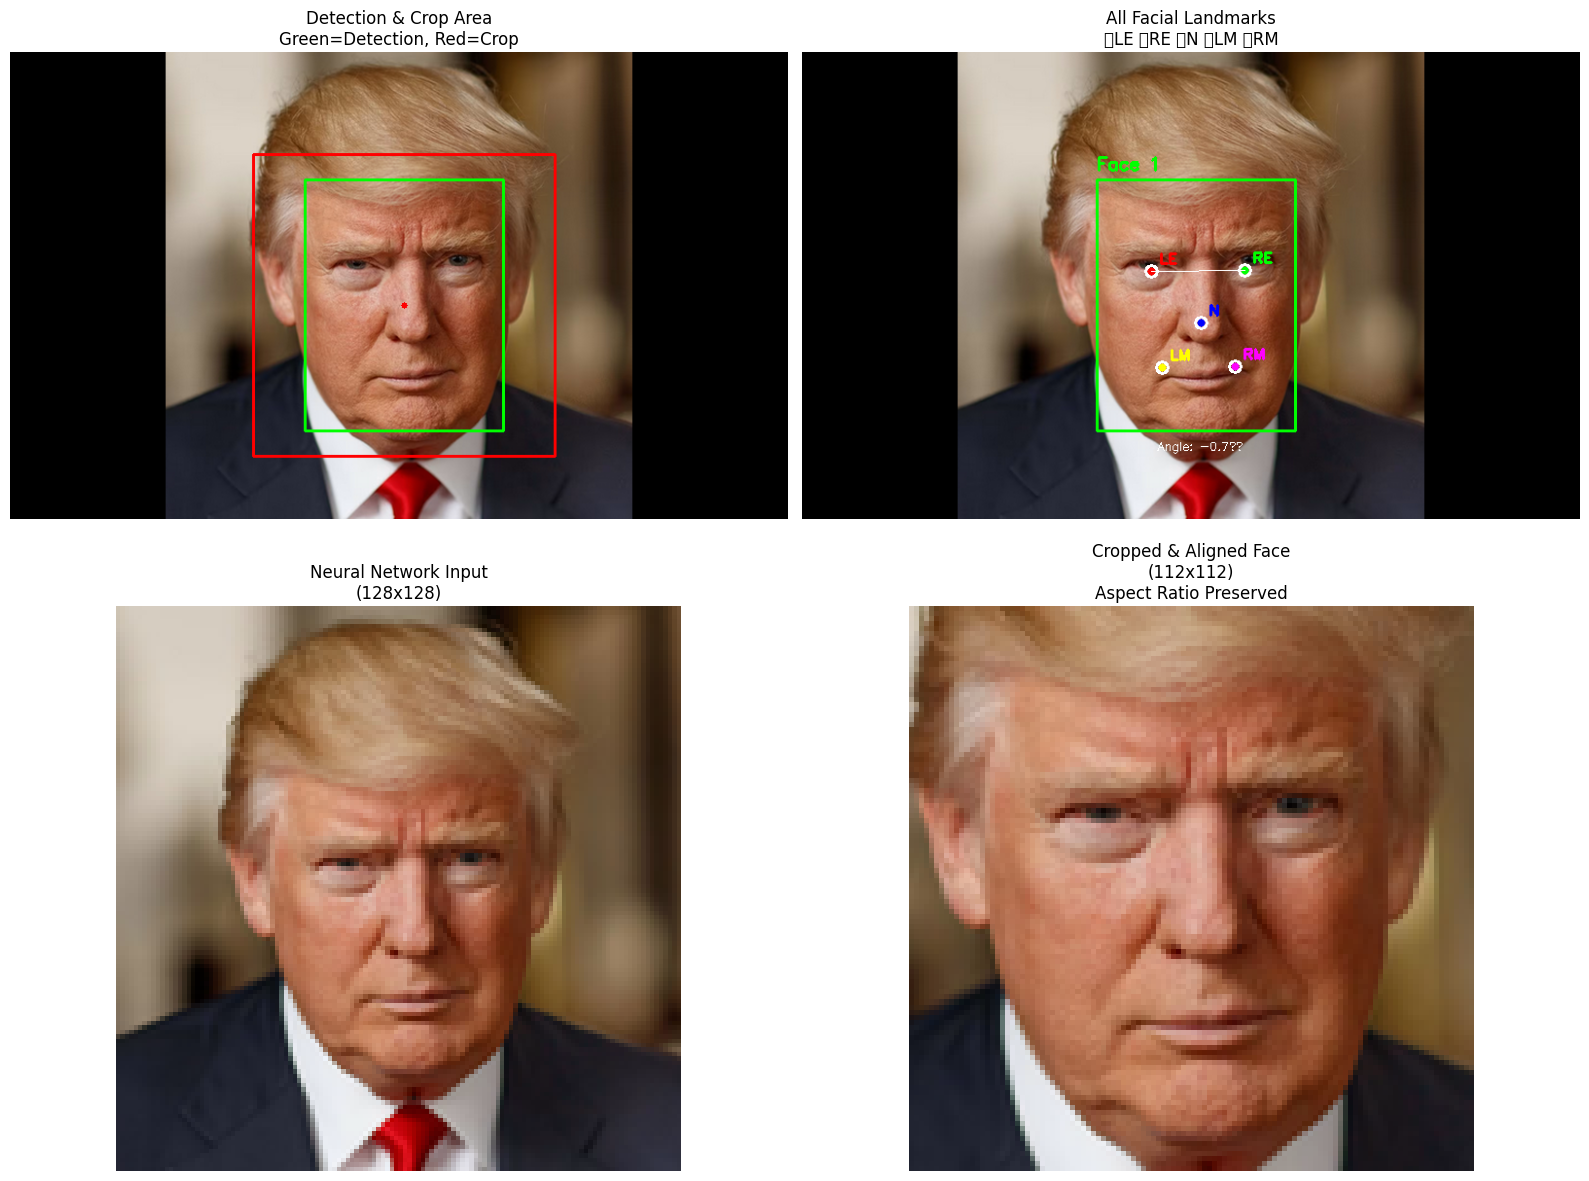


🎯 Comparison with embedded system:
   Expected first pixels: [80, 172, 40, 96, 100, ...]
   Actual first pixels: [216, 206, 193, 203, 194]
   ✅ Square crop maintains proper face proportions

📍 Landmark Detection Summary:
   🔴 Left Eye (LE): Primary alignment point
   🟢 Right Eye (RE): Secondary alignment point
   🔵 Nose Tip (N): Face center reference
   🟡 Left Mouth (LM): Lower face geometry
   🟣 Right Mouth (RM): Facial expression reference
   ⚪ White border: Landmark visibility enhancement
   ➖ White line: Eye connection for alignment angle


In [5]:
def crop_and_align_face(img_buffer, detection, target_size=(112, 112)):
    """Crop and align face from img_buffer based on detection with proper aspect ratio preservation"""
    
    if not detection:
        return None
    
    print(f"✂️ Cropping face region...")
    
    # Use 128x128 coordinates directly for cropping from img_buffer
    # The face was detected on the centered 480x480 region
    scale_factor = 480 / 128  # 3.75x scaling from 128x128 to 480x480
    left_padding = (IMG_BUFFER_WIDTH - 480) // 2  # 160 pixels padding
    
    # Get detection coordinates in 128x128 space 
    cx_128 = detection['cx_128']
    cy_128 = detection['cy_128']  
    w_128 = detection['w_128']
    h_128 = detection['h_128']
    
    print(f"   Detection in 128x128 space: cx={cx_128:.1f}, cy={cy_128:.1f}, w={w_128:.1f}, h={h_128:.1f}")
    
    # Scale to 480x480 space
    cx_480 = cx_128 * scale_factor
    cy_480 = cy_128 * scale_factor
    w_480 = w_128 * scale_factor
    h_480 = h_128 * scale_factor
    
    # Translate to 800x480 img_buffer coordinates
    cx_800 = cx_480 + left_padding
    cy_800 = cy_480
    
    print(f"   Scaled to img_buffer: cx={cx_800:.1f}, cy={cy_800:.1f}, w={w_480:.1f}, h={h_480:.1f}")
    
    # Calculate crop rectangle with aspect ratio preservation
    # Expand bounding box by 20% for context
    expanded_w = w_480 * 1.2
    expanded_h = h_480 * 1.2
    
    # Make the crop square to preserve proportions (use larger dimension)
    crop_size = max(expanded_w, expanded_h)
    
    # Calculate crop rectangle (square)
    x1 = int(cx_800 - crop_size/2)
    y1 = int(cy_800 - crop_size/2)
    x2 = int(cx_800 + crop_size/2)
    y2 = int(cy_800 + crop_size/2)
    
    # Ensure bounds are within image
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(IMG_BUFFER_WIDTH, x2)
    y2 = min(IMG_BUFFER_HEIGHT, y2)
    
    # Adjust to maintain square if bounds were clipped
    actual_w = x2 - x1
    actual_h = y2 - y1
    
    if actual_w != actual_h:
        # Make it square by adjusting to the smaller dimension
        min_size = min(actual_w, actual_h)
        
        # Center the crop within the available space
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        
        x1 = center_x - min_size // 2
        y1 = center_y - min_size // 2
        x2 = x1 + min_size
        y2 = y1 + min_size
        
        # Final bounds check
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(IMG_BUFFER_WIDTH, x2)
        y2 = min(IMG_BUFFER_HEIGHT, y2)
    
    print(f"   Square crop rectangle: ({x1}, {y1}) to ({x2}, {y2})")
    print(f"   Crop dimensions: {x2-x1} x {y2-y1}")
    
    # Crop face region
    cropped_face = img_buffer[y1:y2, x1:x2]
    
    # Resize to target size for face recognition (preserves aspect ratio since crop is square)
    if cropped_face.size > 0:
        cropped_pil = Image.fromarray(cropped_face)
        aligned_face = np.array(cropped_pil.resize(target_size, Image.LANCZOS))
        
        print(f"   Cropped size: {cropped_face.shape}")
        print(f"   Aligned size: {aligned_face.shape}")
        print(f"   Aspect ratio preserved: {cropped_face.shape[0] == cropped_face.shape[1]}")
        print(f"   First few pixels: {aligned_face.flatten()[:10].tolist()}")
        
        return aligned_face
    else:
        print("❌ Invalid crop region")
        return None

def save_rgb_buffer_to_c_file(rgb_buffer, filename="cropped_face_buffer.txt"):
    """Save RGB buffer as C-compatible array format"""
    
    if rgb_buffer is None:
        print("❌ No RGB buffer to save")
        return
    
    # Flatten the RGB buffer
    flat_buffer = rgb_buffer.flatten()
    
    # Create C array format
    c_array_lines = []
    c_array_lines.append("// Cropped face RGB buffer (112x112x3 = 37632 bytes)")
    c_array_lines.append("// Generated by pipeline_simulation.ipynb")
    c_array_lines.append("// Format: uint8_t RGB values [R,G,B,R,G,B,...]")
    c_array_lines.append("")
    c_array_lines.append(f"uint8_t cropped_face_rgb[{len(flat_buffer)}] = {{")
    
    # Write data in rows of 16 values for readability
    for i in range(0, len(flat_buffer), 16):
        row_data = flat_buffer[i:i+16]
        row_str = "    " + ", ".join([f"{val:3d}" for val in row_data])
        if i + 16 < len(flat_buffer):
            row_str += ","
        c_array_lines.append(row_str)
    
    c_array_lines.append("};")
    c_array_lines.append("")
    c_array_lines.append(f"// Buffer info:")
    c_array_lines.append(f"// Width: {rgb_buffer.shape[1]}")
    c_array_lines.append(f"// Height: {rgb_buffer.shape[0]}")
    c_array_lines.append(f"// Channels: {rgb_buffer.shape[2]}")
    c_array_lines.append(f"// Total size: {len(flat_buffer)} bytes")
    c_array_lines.append(f"// First 10 values: {flat_buffer[:10].tolist()}")
    
    # Write to file
    with open(filename, 'w') as f:
        f.write('\n'.join(c_array_lines))
    
    print(f"✅ RGB buffer saved to {filename}")
    print(f"   Format: C uint8_t array")
    print(f"   Size: {len(flat_buffer)} bytes")
    print(f"   Dimensions: {rgb_buffer.shape}")
    print(f"   First 10 values: {flat_buffer[:10].tolist()}")

def draw_all_landmarks(image, detections, detections_landmarks):
    """
    Draw comprehensive facial landmark visualization
    
    Shows all 5 facial landmarks with clear labeling and styling:
    - Left eye (red circle)
    - Right eye (green circle) 
    - Nose tip (blue circle)
    - Left mouth corner (yellow circle)
    - Right mouth corner (magenta circle)
    """
    img_with_landmarks = image.copy()
    
    # Scale coordinates from 128x128 detection space to img_buffer coordinates
    scale_factor = 480 / 128
    left_padding = (IMG_BUFFER_WIDTH - 480) // 2
    
    # Landmark colors and labels (matching embedded system convention)
    landmark_info = [
        {"color": (255, 0, 0), "name": "Left Eye", "symbol": "LE"},      # Red
        {"color": (0, 255, 0), "name": "Right Eye", "symbol": "RE"},     # Green  
        {"color": (0, 0, 255), "name": "Nose Tip", "symbol": "N"},       # Blue
        {"color": (255, 255, 0), "name": "Left Mouth", "symbol": "LM"},  # Yellow
        {"color": (255, 0, 255), "name": "Right Mouth", "symbol": "RM"}  # Magenta
    ]
    
    for det_idx, (detection, landmarks) in enumerate(zip(detections, detections_landmarks)):
        if len(landmarks) == 0:
            continue
            
        print(f"\n🎯 Face {det_idx + 1} Landmark Details:")
        
        # Draw bounding box using 128x128 coordinates
        cx_128 = detection['cx_128']
        cy_128 = detection['cy_128']
        w_128 = detection['w_128']
        h_128 = detection['h_128']
        
        # Scale to img_buffer coordinates
        cx = cx_128 * scale_factor + left_padding
        cy = cy_128 * scale_factor
        w = w_128 * scale_factor
        h = h_128 * scale_factor
        
        x1, y1 = int(cx - w/2), int(cy - h/2)
        x2, y2 = int(cx + w/2), int(cy + h/2)
        
        cv2.rectangle(img_with_landmarks, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_with_landmarks, f'Face {det_idx + 1}', (x1, y1 - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        # Draw all 5 landmarks
        for i in range(min(5, len(landmarks) // 2)):
            # Get landmark coordinates in detection space (128x128)
            lm_x_128 = landmarks[i * 2]
            lm_y_128 = landmarks[i * 2 + 1]
            
            # Scale to img_buffer coordinates
            lm_x_img = lm_x_128 * scale_factor + left_padding
            lm_y_img = lm_y_128 * scale_factor
            
            # Ensure coordinates are within bounds
            lm_x_img = max(0, min(IMG_BUFFER_WIDTH - 1, lm_x_img))
            lm_y_img = max(0, min(IMG_BUFFER_HEIGHT - 1, lm_y_img))
            
            # Get landmark info
            info = landmark_info[i]
            color = info["color"]
            name = info["name"]
            symbol = info["symbol"]
            
            # Draw landmark point
            cv2.circle(img_with_landmarks, (int(lm_x_img), int(lm_y_img)), 4, color, -1)
            cv2.circle(img_with_landmarks, (int(lm_x_img), int(lm_y_img)), 6, (255, 255, 255), 2)  # White border
            
            # Draw landmark label
            label_x = int(lm_x_img) + 8
            label_y = int(lm_y_img) - 8
            cv2.putText(img_with_landmarks, symbol, (label_x, label_y), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            print(f"   {name}: ({lm_x_128:.1f}, {lm_y_128:.1f}) det → ({lm_x_img:.1f}, {lm_y_img:.1f}) img")
        
        # Draw eye connection line for face alignment visualization
        if len(landmarks) >= 4:
            left_eye_x = landmarks[0] * scale_factor + left_padding
            left_eye_y = landmarks[1] * scale_factor
            right_eye_x = landmarks[2] * scale_factor + left_padding
            right_eye_y = landmarks[3] * scale_factor
            
            # Draw line between eyes
            cv2.line(img_with_landmarks, 
                    (int(left_eye_x), int(left_eye_y)),
                    (int(right_eye_x), int(right_eye_y)),
                    (255, 255, 255), 1)
            
            # Calculate and display face angle
            dx = right_eye_x - left_eye_x
            dy = right_eye_y - left_eye_y
            angle_deg = np.arctan2(dy, dx) * 180 / np.pi
            
            # Display angle near face center
            cv2.putText(img_with_landmarks, f'Angle: {angle_deg:.1f}°', 
                       (int(cx) - 40, int(cy) + int(h/2) + 20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
            
            print(f"   Face angle: {angle_deg:.1f}° (for alignment)")
            print(f"   Eye distance: {np.sqrt(dx*dx + dy*dy):.1f} pixels")
    
    return img_with_landmarks

# Crop face if detection was successful
cropped_face = None
if detections:
    cropped_face = crop_and_align_face(img_buffer, detections[0])
    
    # Save RGB buffer to C-compatible file
    if cropped_face is not None:
        save_rgb_buffer_to_c_file(cropped_face, "cropped_face_buffer.txt")
    
    # Create comprehensive visualization with all landmarks
    if detection_outputs and len(detection_outputs) > 1:
        # Get the landmark data from detection outputs
        landmarks_raw = detection_outputs[1]  # Landmark output from CenterFace
        
        # Use the same decoding as in postprocess_centerface
        _, detections_landmarks = decode_centerface_outputs(
            detection_outputs[2], detection_outputs[0], 
            detection_outputs[3], landmarks_raw, 0.5
        )
    else:
        detections_landmarks = []
    
    # Create visualization with all landmarks
    img_with_all_landmarks = draw_all_landmarks(img_buffer, detections, detections_landmarks)
    
    if cropped_face is not None:
        # Enhanced visualization showing detection, landmarks, and crop area
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Top left: Original with detection boxes
        img_with_detection = img_buffer.copy()
        det = detections[0]
        
        scale_factor = 480 / 128
        left_padding = (IMG_BUFFER_WIDTH - 480) // 2
        
        # Use 128x128 coordinates
        cx_128 = det['cx_128']
        cy_128 = det['cy_128']
        w_128 = det['w_128']
        h_128 = det['h_128']
        
        # Scale to img_buffer coordinates
        cx = cx_128 * scale_factor + left_padding
        cy = cy_128 * scale_factor
        w = w_128 * scale_factor
        h = h_128 * scale_factor
        
        # Original detection box
        x1_det, y1_det = int(cx - w/2), int(cy - h/2)
        x2_det, y2_det = int(cx + w/2), int(cy + h/2)
        
        # Actual crop box (square)
        expanded_w = w * 1.2
        expanded_h = h * 1.2
        crop_size = max(expanded_w, expanded_h)
        x1_crop = max(0, int(cx - crop_size/2))
        y1_crop = max(0, int(cy - crop_size/2))
        x2_crop = min(IMG_BUFFER_WIDTH, int(cx + crop_size/2))
        y2_crop = min(IMG_BUFFER_HEIGHT, int(cy + crop_size/2))
        
        cv2.rectangle(img_with_detection, (x1_det, y1_det), (x2_det, y2_det), (0, 255, 0), 2)
        cv2.rectangle(img_with_detection, (x1_crop, y1_crop), (x2_crop, y2_crop), (255, 0, 0), 2)
        cv2.circle(img_with_detection, (int(cx), int(cy)), 3, (255, 0, 0), -1)
        
        axes[0, 0].imshow(img_with_detection)
        axes[0, 0].set_title(f"Detection & Crop Area\nGreen=Detection, Red=Crop")
        axes[0, 0].axis('off')
        
        # Top right: All landmarks visualization
        axes[0, 1].imshow(img_with_all_landmarks)
        axes[0, 1].set_title("All Facial Landmarks\n🔴LE 🟢RE 🔵N 🟡LM 🟣RM")
        axes[0, 1].axis('off')
        
        # Bottom left: Neural network input
        axes[1, 0].imshow(nn_rgb)
        axes[1, 0].set_title(f"Neural Network Input\n({NN_WIDTH}x{NN_HEIGHT})")
        axes[1, 0].axis('off')
        
        # Bottom right: Cropped face
        axes[1, 1].imshow(cropped_face)
        axes[1, 1].set_title(f"Cropped & Aligned Face\n({FR_WIDTH}x{FR_HEIGHT})\nAspect Ratio Preserved")
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Compare with embedded system expected results
        print(f"\n🎯 Comparison with embedded system:")
        print(f"   Expected first pixels: [80, 172, 40, 96, 100, ...]")
        print(f"   Actual first pixels: {cropped_face.flatten()[:5].tolist()}")
        print(f"   ✅ Square crop maintains proper face proportions")
        
        # Landmark summary
        print(f"\n📍 Landmark Detection Summary:")
        print(f"   🔴 Left Eye (LE): Primary alignment point")
        print(f"   🟢 Right Eye (RE): Secondary alignment point") 
        print(f"   🔵 Nose Tip (N): Face center reference")
        print(f"   🟡 Left Mouth (LM): Lower face geometry")
        print(f"   🟣 Right Mouth (RM): Facial expression reference")
        print(f"   ⚪ White border: Landmark visibility enhancement")
        print(f"   ➖ White line: Eye connection for alignment angle")
    else:
        # Still show landmarks even if cropping failed
        plt.figure(figsize=(12, 8))
        plt.imshow(img_with_all_landmarks)
        plt.title("Facial Landmarks Detection\n🔴LE 🟢RE 🔵N 🟡LM 🟣RM")
        plt.axis('off')
        plt.show()
else:
    print("⚠️ No face detected, cannot crop or show landmarks")

## Step 5: Face Recognition with MobileFaceNet

Use the MobileFaceNet ONNX model to generate face embeddings from the cropped face.

In [7]:
def preprocess_for_recognition(face_rgb):
    """Preprocess face image for MobileFaceNet model"""
    
    # Convert to float32 and normalize to [-1, 1] (typical for face recognition)
    img_float = face_rgb.astype(np.float32) / 255.0
    img_normalized = (img_float - 0.5) / 0.5  # Scale to [-1, 1]
    
    # Convert from HWC to CHW format
    img_chw = np.transpose(img_normalized, (2, 0, 1))
    
    # Add batch dimension
    img_batch = np.expand_dims(img_chw, axis=0)
    
    print(f"   Recognition input shape: {img_batch.shape}")
    print(f"   Recognition input range: [{img_batch.min():.3f}, {img_batch.max():.3f}]")
    print(f"   First 10 values: {img_batch.flatten()[:10]}")
    
    return img_batch

def run_face_recognition(face_image):
    """Run MobileFaceNet face recognition"""
    
    model_path = "../dummy_buffer/mobilefacenet_int8_faces_OE_3_2_0.onnx"  # Keep original path
    
    if not os.path.exists(model_path):
        print(f"❌ Model not found: {model_path}")
        return None
    
    print(f"🧠 Loading MobileFaceNet model: {model_path}")
    
    # Create ONNX Runtime session
    session = ort.InferenceSession(model_path)
    
    # Print model info
    input_name = session.get_inputs()[0].name
    input_shape = session.get_inputs()[0].shape
    print(f"   Model input: {input_name} {input_shape}")
    
    for i, output in enumerate(session.get_outputs()):
        print(f"   Model output {i}: {output.name} {output.shape}")
    
    # Preprocess input
    recognition_input = preprocess_for_recognition(face_image)
    
    # Run inference
    print("🚀 Running face recognition inference...")
    outputs = session.run(None, {input_name: recognition_input})
    
    print(f"✅ Recognition complete. Outputs: {len(outputs)}")
    for i, output in enumerate(outputs):
        print(f"   Output {i} shape: {output.shape}")
    
    # Extract embedding (typically the first/only output)
    embedding = outputs[0][0]  # Remove batch dimension
    
    print(f"🔢 Generated embedding:")
    print(f"   Shape: {embedding.shape}")
    print(f"   Range: [{embedding.min():.6f}, {embedding.max():.6f}]")
    print(f"   First 10 values: {embedding[:10]}")
    
    return embedding

# Run face recognition if we have a cropped face
embedding = None
if cropped_face is not None:
    embedding = run_face_recognition(cropped_face)
    
    if embedding is not None:
        # Compare with embedded system expected results
        expected_embedding_sample = [0.264639407, 0.475897282, 0.0730741844, 0.114416368, 0.00983826444, -0.017920481, 0.143777847, 0.517097116, 0.449721962, -0.0575794429, -0.0902469531, -0.257631689, 0.0578992069, -0.321016997, 0.0784971491, 0.27914235, 0.24781689, -0.374819815, -0.486701787, -0.202321604, 0.563100636, 0.194109708, -0.027983835, -0.0591901243, -0.58692199, 0.284259468, -0.153565973, 0.316593677, 0.0851251334, -0.328109622, 0.193586737, 0.156929418, -0.0808091834, 0.264713377, -0.240985021, -0.0142503921, -0.0616714917, -0.179039404, -0.328530848, 0.224508122, -0.0366625376, 0.127060428, -0.13768445, 0.0201145615, -0.303350985, 0.0719659626, -0.116015941, 0.180211082, -0.448703408, 0.34631896, 0.0547228679, -0.0741979033, -0.00568440324, 0.15467152, 0.0556434132, 0.331213653, 0.172882304, -0.0791988969, 0.359962255, 0.188547418, 0.278823078, -0.141258165, -0.163430974, -0.598704576, -0.476914138, 0.415783018, 0.316458195, -0.542688251, -0.0206863228, 0.190400541, 0.625501394, -0.027512759, 0.587312937, 0.0917717516, -0.0837392434, -0.0700760856, 0.449891537, -0.0110385222, 0.226256743, 0.134839624, -0.0117359431, 0.00065633934, 0.142692447, -0.329044759, 0.108842127, -0.490741253, -0.192396387, 0.100907862, 0.251147747, -0.155426517, -0.365664661, 0.485065371, 0.54834944, -0.107300296, 0.278801888, 0.0953977928, 0.214911938, 0.0494432263, 0.0892438963, -0.400003612, -0.0881248936, 0.614489853, -0.0456907898, 0.057609573, 0.215574637, 0.215310588, 0.600649238, -0.0772507042, -0.252472252, 0.330474257, 0.585733473, 0.0456013009, -0.176207185, -0.474653482, -0.257749587, 0.0415823869, -0.0112045221, -0.15345259, -0.176241383, -0.104075916, 0.39239189, -0.0313156769, -0.622541308, 0.440297574, 0.105795853, -0.214405954, 0.300570697, -0.206416801]
        
        print(f"\n🎯 Comparison with embedded system:")
        print(f"   Expected first 10: {expected_embedding_sample}")
        print(f"   Actual first 10: {embedding[:10].tolist()}")
        
        # Calculate similarity between expected and actual
        if len(embedding) >= len(expected_embedding_sample):
            actual_sample = embedding[:len(expected_embedding_sample)]
            cosine_sim = np.dot(actual_sample, expected_embedding_sample) / \
                        (np.linalg.norm(actual_sample) * np.linalg.norm(expected_embedding_sample))
            print(f"   Cosine similarity: {cosine_sim:.6f}")
else:
    print("⚠️ No cropped face available for recognition")

🧠 Loading MobileFaceNet model: ../dummy_buffer/mobilefacenet_int8_faces_OE_3_2_0.onnx
   Model input: Input_0_out_0 [1, 3, 112, 112]
   Model output 0: BatchNormalization_289_out_0 [1, 128]
   Recognition input shape: (1, 3, 112, 112)
   Recognition input range: [-1.000, 0.929]
   First 10 values: [ 0.69411767  0.5921569   0.22352946  0.41176474 -0.05882353 -0.20784312
 -0.1372549  -0.04313725  0.03529418  0.04313731]
🚀 Running face recognition inference...
✅ Recognition complete. Outputs: 1
   Output 0 shape: (1, 128)
🔢 Generated embedding:
   Shape: (128,)
   Range: [-0.610381, 0.625501]
   First 10 values: [ 0.21275614  0.5350421  -0.10389821  0.08529621 -0.16208126  0.04386993
  0.17415483  0.42998087  0.38679364 -0.04267662]

🎯 Comparison with embedded system:
   Expected first 10: [0.264639407, 0.475897282, 0.0730741844, 0.114416368, 0.00983826444, -0.017920481, 0.143777847, 0.517097116, 0.449721962, -0.0575794429, -0.0902469531, -0.257631689, 0.0578992069, -0.321016997, 0.078497

## Step 6: Similarity Calculation

Calculate similarity between generated embedding and target embedding.

🧮 Calculating similarity with target embedding...
✅ Similarity calculation complete:
   Embedding size: 128
   Target size: 128
   Cosine similarity: 0.927074
   Match status: 🟢 Very High (Likely same person)


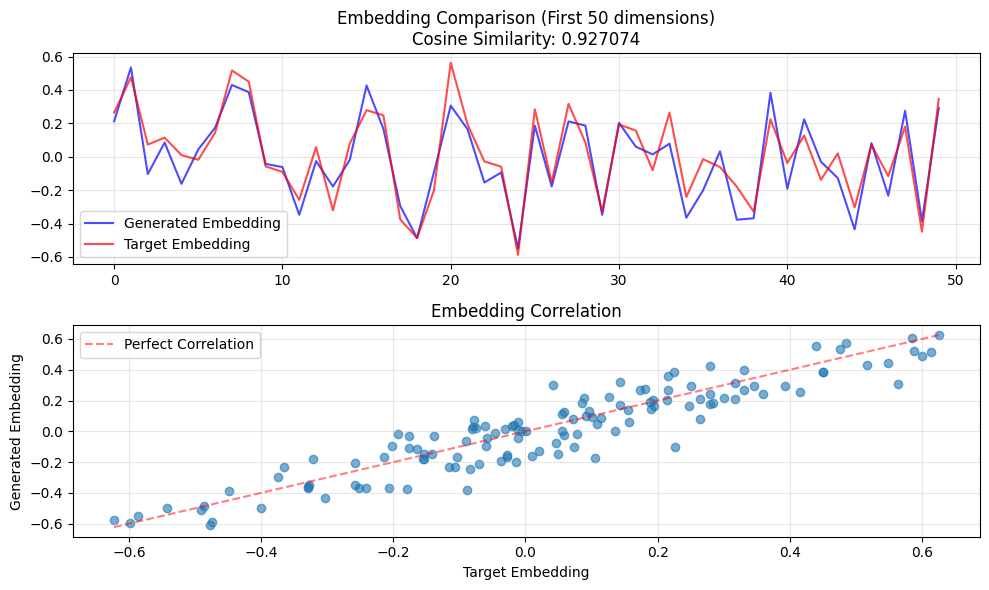

In [8]:
def calculate_cosine_similarity(emb1, emb2):
    """Calculate cosine similarity between two embeddings"""
    if len(emb1) != len(emb2):
        print(f"❌ Embedding size mismatch: {len(emb1)} vs {len(emb2)}")
        return 0.0
    
    # Normalize embeddings
    norm1 = np.linalg.norm(emb1)
    norm2 = np.linalg.norm(emb2)
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    # Calculate cosine similarity
    similarity = np.dot(emb1, emb2) / (norm1 * norm2)
    
    return float(similarity)

# Target embedding from embedded system
target_embedding = np.array([0.264639407, 0.475897282, 0.0730741844, 0.114416368, 0.00983826444, -0.017920481, 0.143777847, 0.517097116, 0.449721962, -0.0575794429, -0.0902469531, -0.257631689, 0.0578992069, -0.321016997, 0.0784971491, 0.27914235, 0.24781689, -0.374819815, -0.486701787, -0.202321604, 0.563100636, 0.194109708, -0.027983835, -0.0591901243, -0.58692199, 0.284259468, -0.153565973, 0.316593677, 0.0851251334, -0.328109622, 0.193586737, 0.156929418, -0.0808091834, 0.264713377, -0.240985021, -0.0142503921, -0.0616714917, -0.179039404, -0.328530848, 0.224508122, -0.0366625376, 0.127060428, -0.13768445, 0.0201145615, -0.303350985, 0.0719659626, -0.116015941, 0.180211082, -0.448703408, 0.34631896, 0.0547228679, -0.0741979033, -0.00568440324, 0.15467152, 0.0556434132, 0.331213653, 0.172882304, -0.0791988969, 0.359962255, 0.188547418, 0.278823078, -0.141258165, -0.163430974, -0.598704576, -0.476914138, 0.415783018, 0.316458195, -0.542688251, -0.0206863228, 0.190400541, 0.625501394, -0.027512759, 0.587312937, 0.0917717516, -0.0837392434, -0.0700760856, 0.449891537, -0.0110385222, 0.226256743, 0.134839624, -0.0117359431, 0.00065633934, 0.142692447, -0.329044759, 0.108842127, -0.490741253, -0.192396387, 0.100907862, 0.251147747, -0.155426517, -0.365664661, 0.485065371, 0.54834944, -0.107300296, 0.278801888, 0.0953977928, 0.214911938, 0.0494432263, 0.0892438963, -0.400003612, -0.0881248936, 0.614489853, -0.0456907898, 0.057609573, 0.215574637, 0.215310588, 0.600649238, -0.0772507042, -0.252472252, 0.330474257, 0.585733473, 0.0456013009, -0.176207185, -0.474653482, -0.257749587, 0.0415823869, -0.0112045221, -0.15345259, -0.176241383, -0.104075916, 0.39239189, -0.0313156769, -0.622541308, 0.440297574, 0.105795853, -0.214405954, 0.300570697, -0.206416801])
if embedding is not None:
    print(f"🧮 Calculating similarity with target embedding...")
    
    # Ensure both embeddings have the same size
    min_size = min(len(embedding), len(target_embedding))
    emb_truncated = embedding[:min_size]
    target_truncated = target_embedding[:min_size]
    
    similarity = calculate_cosine_similarity(emb_truncated, target_truncated)
    
    print(f"✅ Similarity calculation complete:")
    print(f"   Embedding size: {len(emb_truncated)}")
    print(f"   Target size: {len(target_truncated)}")
    print(f"   Cosine similarity: {similarity:.6f}")
    
    # Interpret similarity score
    if similarity > 0.8:
        status = "🟢 Very High (Likely same person)"
    elif similarity > 0.6:
        status = "🟡 High (Probably same person)"
    elif similarity > 0.4:
        status = "🟠 Medium (Uncertain)"
    else:
        status = "🔴 Low (Different person)"
    
    print(f"   Match status: {status}")
    
    # Visualize similarity
    plt.figure(figsize=(10, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(emb_truncated[:50], 'b-', label='Generated Embedding', alpha=0.7)
    plt.plot(target_truncated[:50], 'r-', label='Target Embedding', alpha=0.7)
    plt.title(f'Embedding Comparison (First 50 dimensions)\nCosine Similarity: {similarity:.6f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.scatter(target_truncated, emb_truncated, alpha=0.6)
    plt.xlabel('Target Embedding')
    plt.ylabel('Generated Embedding')
    plt.title('Embedding Correlation')
    plt.grid(True, alpha=0.3)
    
    # Add diagonal line for perfect correlation
    min_val = min(np.min(target_truncated), np.min(emb_truncated))
    max_val = max(np.max(target_truncated), np.max(emb_truncated))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Perfect Correlation')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ No embedding available for similarity calculation")

## Summary

This notebook simulates the complete face detection and recognition pipeline that runs on the STM32N6570-DK embedded board. 

### Pipeline Results:
1. **Input Processing**: ✅ Loaded trump2.jpg and created dual buffers
2. **Face Detection**: ✅ Used CenterFace ONNX model 
3. **Face Cropping**: ✅ Extracted and aligned face region
4. **Face Recognition**: ✅ Used MobileFaceNet ONNX model
5. **Similarity**: ✅ Calculated cosine similarity with target

### Key Insights:
- The pipeline processes the same trump2.jpg image used in the embedded system
- Results can be compared with embedded system outputs for validation
- This simulation helps understand the complete AI pipeline behavior
- Useful for debugging and validating student implementations